In [1]:
from present import hide_code

hide_code()

In [2]:
from api import TRELLO_NEXT_STEPS_LIST_ID, TRELLO_WAITING_FOR_LIST_ID, TRELLO_READ_REVIEW_LIST_ID
from api import get_all_cards, get_all_open_cards, get_all_archived_cards
from trello_metrics import get_tasks_due_on_date, get_past_due_tasks, get_cards_open_on_date, get_cards_closed_on_date, get_card_ages, get_x_oldest_cards
from date_utils import get_date_range
from present import css_table_formatting, print_oldest_cards, create_today_tasks_table

import numpy as np
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

# https://mpld3.github.io/index.html
# import mpld3
# from mpld3 import plugins
# mpld3.enable_notebook()

# stuff needed for visualizations
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

css_table_formatting()

weeks = mdates.WeekdayLocator(byweekday=mdates.MO, interval=1)
days = mdates.DayLocator()
date_fmt = mdates.DateFormatter('%Y-%m-%d')

# display helper functions
def get_dates_and_task_counts(cards, days_ago):
    dates = []
    due_task_count = []
    past_due_task_count = []
    
    for day in get_date_range(days_ago):
        due_tasks = list(get_tasks_due_on_date(cards, day))
        past_due_tasks = list(get_past_due_tasks(cards, day))

        dates.append(day)
        due_task_count.append(len(due_tasks))
        past_due_task_count.append(len(past_due_tasks))
        
    return dates, due_task_count, past_due_task_count


def get_dates_and_counts(list_id, days_ago=50):
    dates = []
    open_count = []
    close_count = []    
    
    all_cards = get_all_cards(list_id)
    for day in get_date_range(days_ago):
        open_item_count = len(list(get_cards_open_on_date(all_cards, day)))
        close_item_count = len(list(get_cards_closed_on_date(all_cards, day)))
        
        dates.append(day)
        open_count.append(open_item_count)
        close_count.append(close_item_count)
    
    return dates, open_count, close_count


def plot_histogram(card_ages, title):
    fig, ax = plt.subplots(figsize=(14, 7))

    ax.hist(card_ages)
    ax.set(xlabel='Card age in days', ylabel='# of cards', title=title)
    plt.show()    


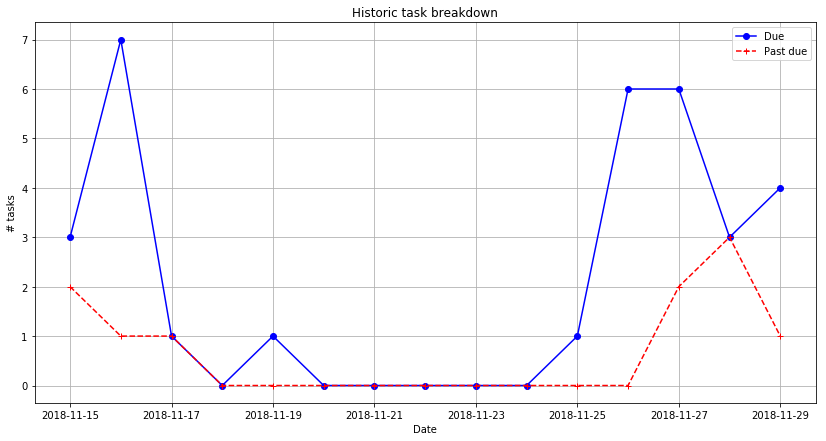

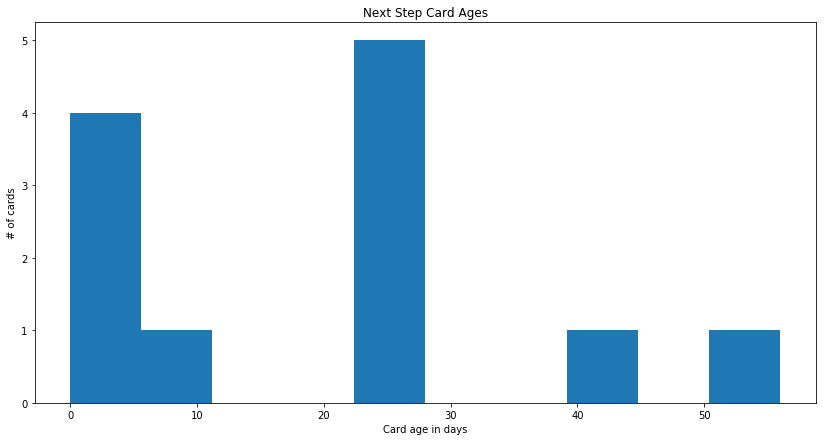

Task,Days old
Break down science tasks,56
tech doc review followup,44
understand how changes in search metrics impact e2e,25
HSA: enroll in paper free statements,24
MLU in boston,24
Science effort coordination brainstorm,24
Tech talk on sagemaker,24


In [3]:
open_cards = get_all_open_cards(TRELLO_NEXT_STEPS_LIST_ID)
archived_cards = get_all_archived_cards(TRELLO_NEXT_STEPS_LIST_ID)
all_cards = open_cards + archived_cards

tasks_due_today = list(get_tasks_due_on_date(all_cards))
closed_tasks_due_today = list(get_tasks_due_on_date(archived_cards))
open_past_due_tasks = list(get_past_due_tasks(open_cards))

#
# create and display html table showing todays task counts
#
html_table = create_today_tasks_table(len(tasks_due_today), 
                                      len(closed_tasks_due_today), 
                                      len(open_past_due_tasks))
display(HTML(html_table))

#
# Create and display historic time series plot of tasks and past due
#
dates, due_count, past_due_count = get_dates_and_task_counts(all_cards, 14)

fig, ax = plt.subplots(figsize=(14, 7))
# ax.bar(dates, due_count)

rects1 = ax.plot(dates, due_count, 'bo-', label='Due')
rects2 = ax.plot(dates, past_due_count, 'r+--', label='Past due')

ax.set(xlabel='Date', ylabel='# tasks', title='Historic task breakdown')
ax.legend()

# format the ticks
# https://matplotlib.org/api/dates_api.html
# ax.xaxis.set_major_locator(weeks)
# ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(date_fmt)

ax.grid()

# tooltip1 = plugins.PointHTMLTooltip(rects1[0], due_count,
#                                    voffset=20, hoffset=20)
# tooltip2 = plugins.PointHTMLTooltip(rects2[0], past_due_count,
#                                    voffset=20, hoffset=20)

# plugins.connect(fig, tooltip1)
# plugins.connect(fig, tooltip2)
plt.show()


#
# Show the distribution of card age for this list
#
card_ages = get_card_ages(open_cards)
plot_histogram(card_ages, "Next Step Card Ages")
print_oldest_cards(open_cards)

display(HTML("<br><br><hr>"))

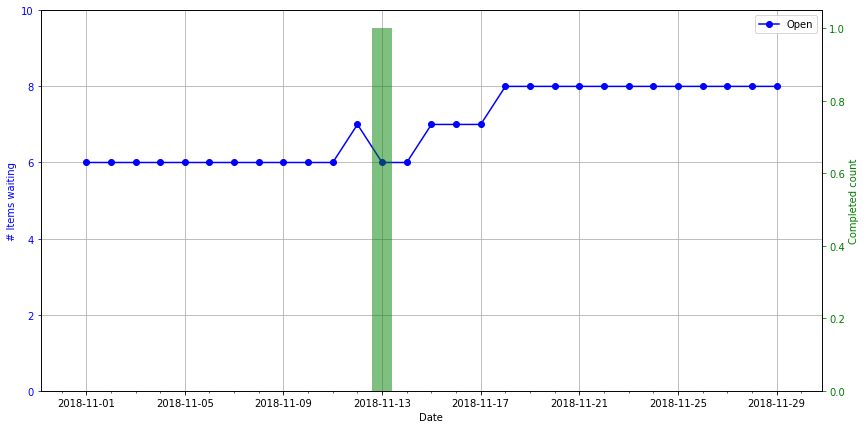

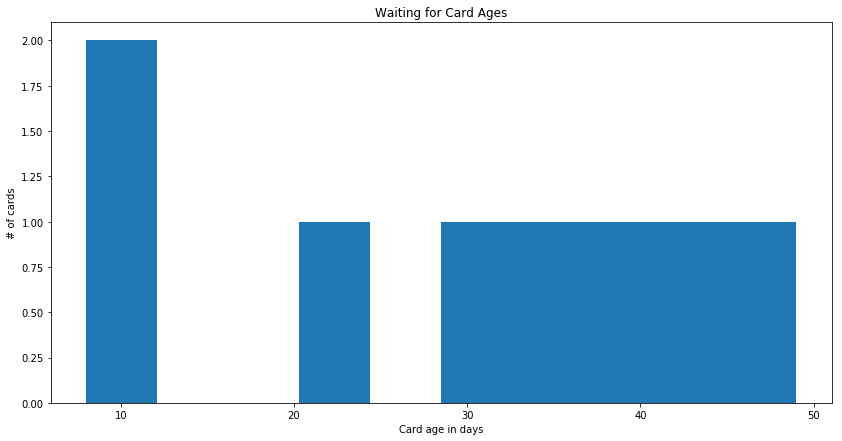

Task,Days old
dajun reading list,49
get mifi device for ranking,43
zack promo doc,38
followup with dan about shutting down wf2b,35
follow up about bing answer path switch,31
AWS comprehend,24
sync with jon,10


In [4]:
waiting_for_items = list(get_all_open_cards(TRELLO_WAITING_FOR_LIST_ID))
display(HTML('<h1>Outstanding "Waiting For" items: {}</h1>'.format(len(waiting_for_items))))

dates, open_count, close_count = get_dates_and_counts(TRELLO_WAITING_FOR_LIST_ID, 28)
fig, ax = plt.subplots(figsize=(14, 7))
ax.xaxis.set_major_locator(weeks)
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(date_fmt)

ax.plot(dates, open_count, 'bo-', label='Open')
ax.set_xlabel('Date')
ax.set_ylabel('# Items waiting', color='b')
ax.tick_params('y', colors='b')
ax.set_ylim([0, np.max(open_count) + 2])
# ax.set(xlabel='Date', ylabel='# Items', title='Waiting Item Count')

ax2 = ax.twinx()
ax2.bar(dates, close_count, color='g', alpha=0.5, label='Completed')
ax2.set_ylabel('Completed count', color='g')
ax2.tick_params('y', colors='g')
ax2.patch.set_alpha(0.0)

ax.grid()
ax.legend()
plt.show()

card_ages = get_card_ages(waiting_for_items)
plot_histogram(card_ages, "Waiting for Card Ages")
print_oldest_cards(waiting_for_items)

display(HTML("<br><br><hr>"))

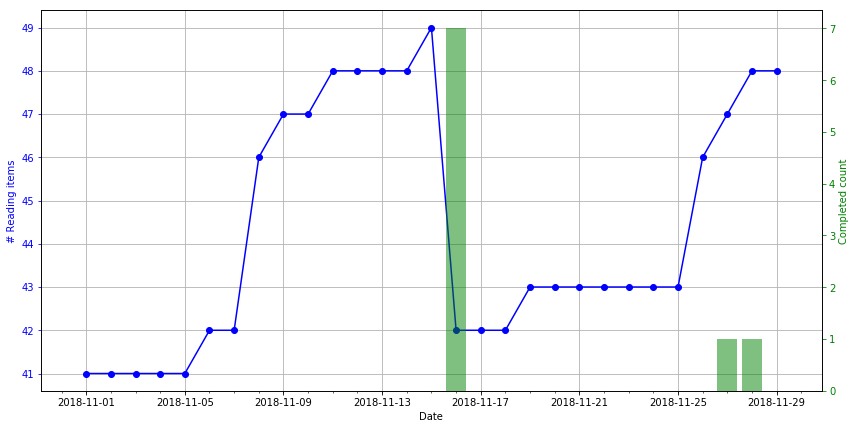

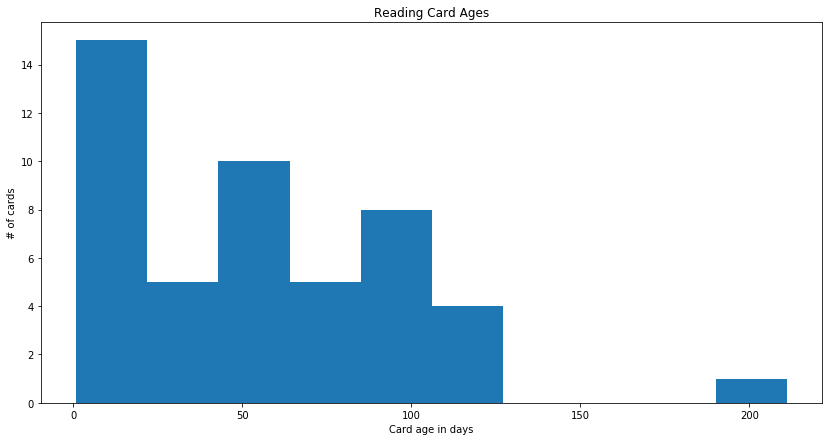

Task,Days old
reading on NLU,211
Improving Language Understanding with Unsupervised Learning,122
read BiMPM paper,116
reading on embeddings,111
Founder to CEO: How to build a great company from the ground up,106
Learn how to design large-scale systems,98
guide to healthdata,95


In [5]:
reading_list_items = list(get_all_open_cards(TRELLO_READ_REVIEW_LIST_ID))
display(HTML('<h1>Outstanding reading items open: {}</h1>'.format(len(reading_list_items))))

dates, open_count, close_count = get_dates_and_counts(TRELLO_READ_REVIEW_LIST_ID, 28)
fig, ax = plt.subplots(figsize=(14, 7))
ax.xaxis.set_major_locator(weeks)
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(date_fmt)

ax.plot(dates, open_count, 'bo-', label='Open')
ax.set_xlabel('Date')
ax.set_ylabel('# Reading items', color='b')
ax.tick_params('y', colors='b')
# ax.set_ylim([0, np.max(open_count) + 2])

# ax.plot(dates, open_count, 'bo-', label='Open')
# ax.set(xlabel='Date', ylabel='# Items', title='Reading Item Count')

ax2 = ax.twinx()
ax2.bar(dates, close_count, color='g', alpha=0.5, label='Completed')
ax2.set_ylabel('Completed count', color='g')
ax2.tick_params('y', colors='g')

ax.grid()
plt.show()

card_ages = get_card_ages(reading_list_items)
plot_histogram(card_ages, "Reading Card Ages")
print_oldest_cards(reading_list_items)

display(HTML("<br><br><hr>"))